Nama : Hendri Mardani - Machine Learning Terapan

Import module yang diperlukan

In [1]:
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
import datetime
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
filterwarnings("ignore")

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### LOAD DATASET

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Machine Learning/london.csv")
data

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1
...,...,...,...,...,...,...,...
13544,2019-09-01,england,249942,E92000001,64605.0,NaN,0
13545,2019-10-01,england,249376,E92000001,68677.0,NaN,0
13546,2019-11-01,england,248515,E92000001,67814.0,NaN,0
13547,2019-12-01,england,250410,E92000001,NaN,NaN,0


### DATA UNDERSTANDING

Cek tipedata masing-masing fitur

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13549 non-null  object 
 1   area           13549 non-null  object 
 2   average_price  13549 non-null  int64  
 3   code           13549 non-null  object 
 4   houses_sold    13455 non-null  float64
 5   no_of_crimes   7439 non-null   float64
 6   borough_flag   13549 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 741.1+ KB


Ubah tipedata object menjadi tipedata datetime

In [5]:
data["date"] = pd.to_datetime(data["date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           13549 non-null  datetime64[ns]
 1   area           13549 non-null  object        
 2   average_price  13549 non-null  int64         
 3   code           13549 non-null  object        
 4   houses_sold    13455 non-null  float64       
 5   no_of_crimes   7439 non-null   float64       
 6   borough_flag   13549 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 741.1+ KB


Cek masing-masing fitur dengan menggunakan statistik, seperti mean, standard deviasi, dll

In [6]:
data.describe()

,average_price,houses_sold,no_of_crimes,borough_flag
count,1.354900e+04,13455.000000,7439.000000,13549.000000
mean,2.635197e+05,3893.994129,2158.352063,0.733338
std,1.876175e+05,12114.402476,902.087742,0.442230
min,4.072200e+04,2.000000,0.000000,0.000000
25%,1.323800e+05,247.000000,1623.000000,0.000000
50%,2.229190e+05,371.000000,2132.000000,1.000000
75%,3.368430e+05,3146.000000,2582.000000,1.000000
max,1.463378e+06,132163.000000,7461.000000,1.000000


### DATA PREPARATION

Cek apakah ada data yang kosong pada masing-masing fitur

In [7]:
data.isnull().sum()

date                0
area                0
average_price       0
code                0
houses_sold        94
no_of_crimes     6110
borough_flag        0
dtype: int64

Hapus kolom yang tidak diperlukan dalam analisis/banyak nilai kosong

In [8]:
data.drop(["no_of_crimes","houses_sold"], axis=1, inplace=True)
data

,date,area,average_price,code,borough_flag
0,1995-01-01,city of london,91449,E09000001,1
1,1995-02-01,city of london,82203,E09000001,1
2,1995-03-01,city of london,79121,E09000001,1
3,1995-04-01,city of london,77101,E09000001,1
4,1995-05-01,city of london,84409,E09000001,1
...,...,...,...,...,...
13544,2019-09-01,england,249942,E92000001,0
13545,2019-10-01,england,249376,E92000001,0
13546,2019-11-01,england,248515,E92000001,0
13547,2019-12-01,england,250410,E92000001,0


Tampilkan visualisasi dalam bentuk violinplot

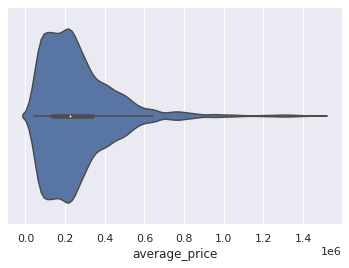

In [9]:
sns.violinplot(x="average_price", data=data);
plt.savefig("violin.jpg")

HAPUS OUTLIER

In [10]:
data_baru = pd.DataFrame(data["average_price"])
limit=3
col=len(data_baru.columns)
rows=len(data_baru.index)
outliers=[]

for i in range(0,col):
    subset=data_baru.iloc[:,i]
    mean_val=np.mean(subset)
    stan_dev=np.std(subset)
    for j in range(0,rows):
        z_score=(subset[j]-mean_val)/stan_dev
        if(np.abs(z_score)>limit):
            if j not in outliers:
                outliers.append((j))
            
hasil=pd.DataFrame(data_baru)
hasil.drop(outliers, axis=0, inplace=True)
print("Outlier yang dihapus adalah ",len(outliers))

Outlier yang dihapus adalah  240


Hapus fitur yang lama, kemudian buat fitur baru

In [11]:
data.drop(["average_price"], axis=1, inplace=True)
data = pd.concat([data, hasil], axis=1)
data.dropna(axis=0, inplace=True)
data

,date,area,code,borough_flag,average_price
0,1995-01-01,city of london,E09000001,1,91449.0
1,1995-02-01,city of london,E09000001,1,82203.0
2,1995-03-01,city of london,E09000001,1,79121.0
3,1995-04-01,city of london,E09000001,1,77101.0
4,1995-05-01,city of london,E09000001,1,84409.0
...,...,...,...,...,...
13544,2019-09-01,england,E92000001,0,249942.0
13545,2019-10-01,england,E92000001,0,249376.0
13546,2019-11-01,england,E92000001,0,248515.0
13547,2019-12-01,england,E92000001,0,250410.0


Tampilkan visualisasi dalam bentuk violinplot

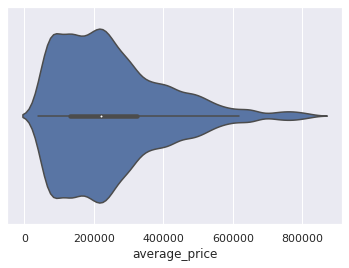

In [12]:
sns.violinplot(x="average_price", data=data);
plt.savefig("violin_2.jpg")

Buat analisis fitur kategori area dalam bntuk barplot

                        jumlah sampel  persentase
hackney                           302         2.3
south east                        302         2.3
enfield                           302         2.3
tower hamlets                     302         2.3
newham                            301         2.3
redbridge                         301         2.3
richmond upon thames              301         2.3
southwark                         301         2.3
sutton                            301         2.3
waltham forest                    301         2.3
wandsworth                        301         2.3
inner london                      301         2.3
outer london                      301         2.3
kingston upon thames              301         2.3
lewisham                          301         2.3
north east                        301         2.3
north west                        301         2.3
yorks and the humber              301         2.3
east midlands                     301         2.3


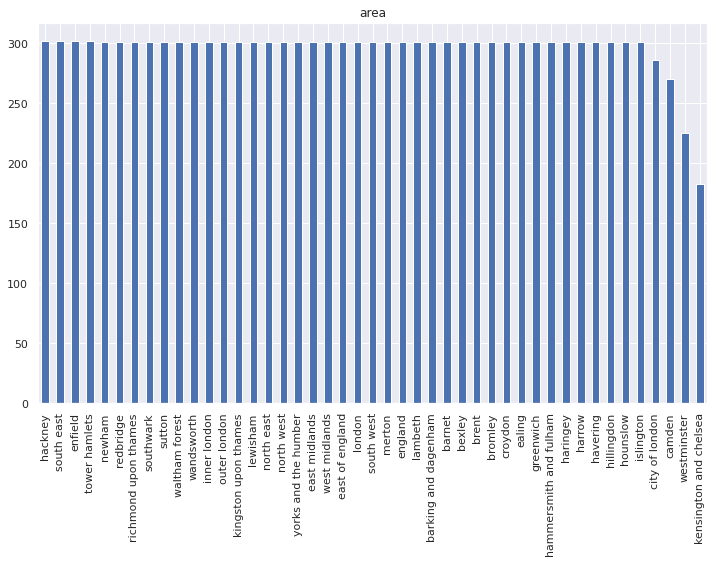

In [13]:
fitur_kategori = ["area","code"]
fitur_angka = ["average_price,""boroguh_flag"]

feature = fitur_kategori[0]
count = data[feature].value_counts()
percent = 100*data[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title=feature, figsize=(12,7));
plt.savefig("bar.jpg")

Buat analisis fitur kategori code dalam bntuk barplot

           jumlah sampel  persentase
E09000012            302         2.3
E12000008            302         2.3
E09000010            302         2.3
E09000030            302         2.3
E09000025            301         2.3
E09000026            301         2.3
E09000027            301         2.3
E09000028            301         2.3
E09000029            301         2.3
E09000031            301         2.3
E09000032            301         2.3
E13000001            301         2.3
E13000002            301         2.3
E09000021            301         2.3
E09000023            301         2.3
E12000001            301         2.3
E12000002            301         2.3
E12000003            301         2.3
E12000004            301         2.3
E12000005            301         2.3
E12000006            301         2.3
E12000007            301         2.3
E12000009            301         2.3
E09000024            301         2.3
E92000001            301         2.3
E09000022            301         2.3
E

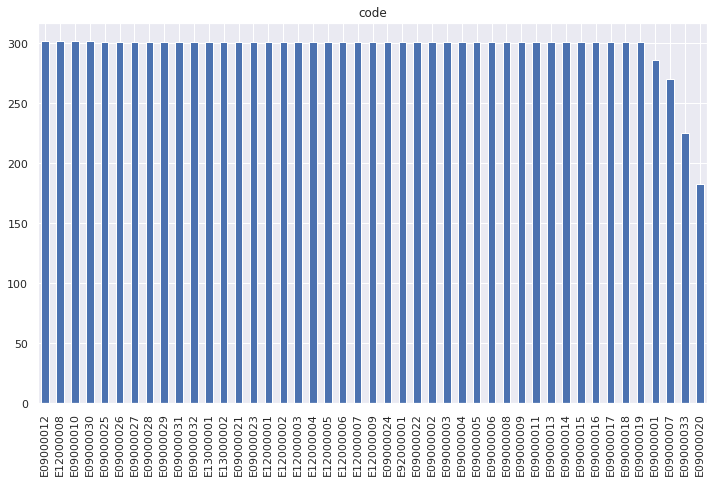

In [14]:
fitur_kategori = ["area","code"]
fitur_angka = ["average_price,""boroguh_flag"]

feature = fitur_kategori[1]
count = data[feature].value_counts()
percent = 100*data[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title=feature, figsize=(12,7));
plt.savefig("bar_2.jpg")

Hapus fitur code

In [15]:
data.drop("code", axis=1, inplace=True)
data

,date,area,borough_flag,average_price
0,1995-01-01,city of london,1,91449.0
1,1995-02-01,city of london,1,82203.0
2,1995-03-01,city of london,1,79121.0
3,1995-04-01,city of london,1,77101.0
4,1995-05-01,city of london,1,84409.0
...,...,...,...,...
13544,2019-09-01,england,0,249942.0
13545,2019-10-01,england,0,249376.0
13546,2019-11-01,england,0,248515.0
13547,2019-12-01,england,0,250410.0


Tampilkan visualisasi dalam bentuk kdeplot

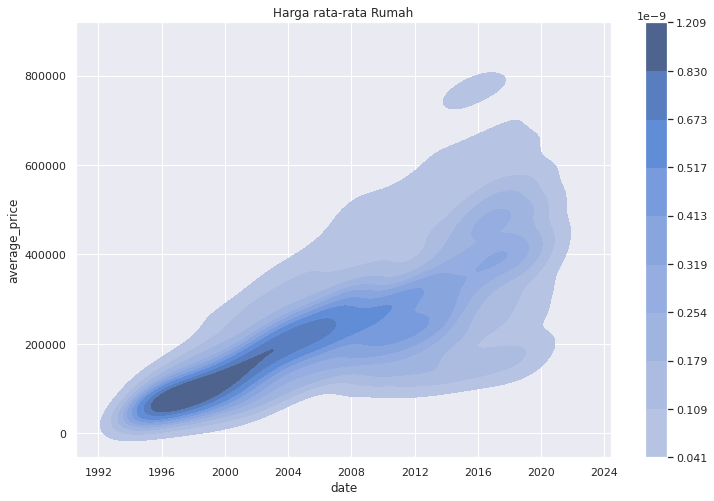

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
sns.kdeplot(x="date", y="average_price", cbar=True, fill=True, data=data)
plt.title("Harga rata-rata Rumah")
plt.savefig("kde.jpg")
plt.show()

Tampilkan visualisasi dalam bentuk barplot

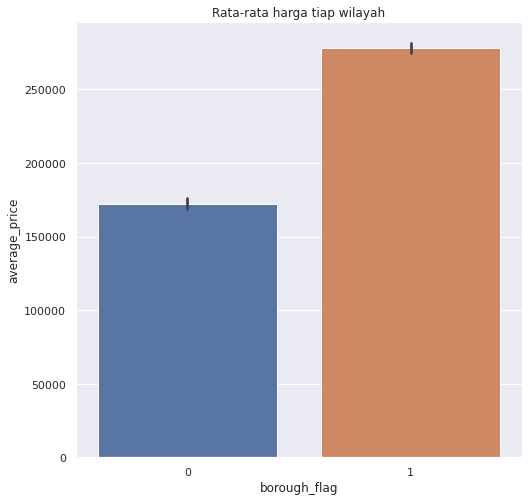

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x="borough_flag", y="average_price", data=data)
plt.title("Rata-rata harga tiap wilayah")
plt.savefig("bar_3.jpg")
plt.show()

Tamplikan visualisasi dalam bentuk scatterplot

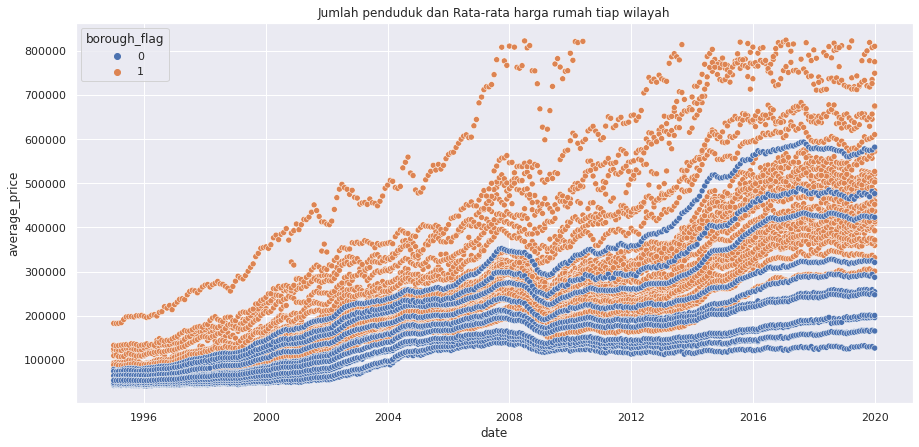

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(x="date", y="average_price", hue="borough_flag", data=data)
plt.title("Jumlah penduduk dan Rata-rata harga rumah tiap wilayah")
plt.savefig("scatter.jpg")
plt.show()

Tampilkan visualisasi fitur numerik dalam bentuk pairplot

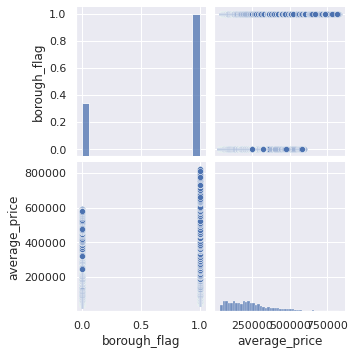

In [19]:
sns.pairplot(data);
plt.savefig("pair.jpg")

Tampilkan fitur-fitur yang saling berkorelasi dalam bentuk fitur numerik

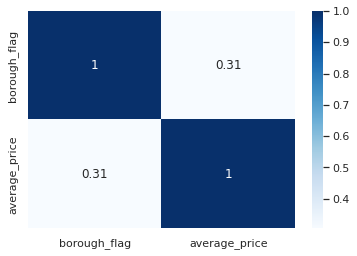

In [20]:
sns.heatmap(data.corr(), annot=True, cmap="Blues");
plt.savefig("heatmap.jpg")

Hapus fitur area

In [21]:
data.drop("area", axis=1, inplace=True)
data

,date,borough_flag,average_price
0,1995-01-01,1,91449.0
1,1995-02-01,1,82203.0
2,1995-03-01,1,79121.0
3,1995-04-01,1,77101.0
4,1995-05-01,1,84409.0
...,...,...,...
13544,2019-09-01,0,249942.0
13545,2019-10-01,0,249376.0
13546,2019-11-01,0,248515.0
13547,2019-12-01,0,250410.0


Split fitur atau pisahkan fitur dalam bentuk fitur trining dan fitur testing

In [22]:
X = data.iloc[:, :1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"Jumlah Baris dan Kolom semuanya = {X.shape[0]}")
print(f"Jumlah Baris dan Kolom training = {X_train.shape[0]}")
print(f"Jumlah Baris dan Kolom test = {X_test.shape[0]}")

Jumlah Baris dan Kolom semuanya = 13309
Jumlah Baris dan Kolom training = 10647
Jumlah Baris dan Kolom test = 2662


Buat salinan fitur testing

In [23]:
X_test_pred = X_test.copy()
X_plot_pred = X_test.copy()

Tampilkan visualisasi dalam bentuk scatterplot

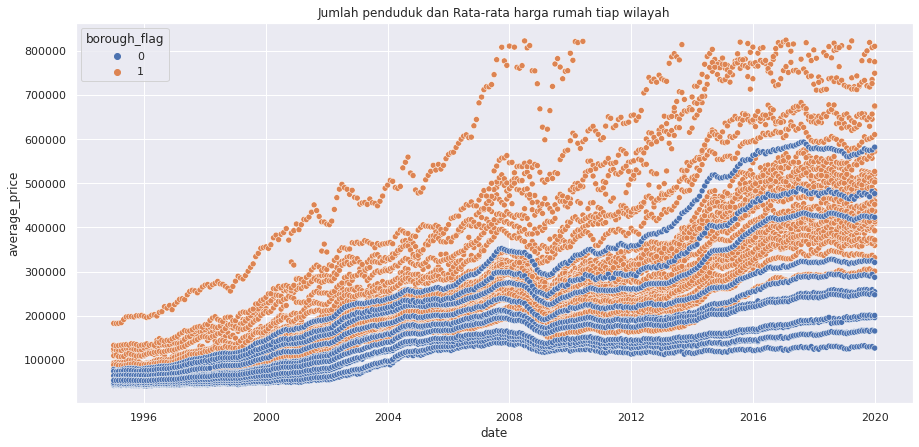

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
sns.scatterplot(x="date", y="average_price", hue="borough_flag", data=data)
plt.title("Jumlah penduduk dan Rata-rata harga rumah tiap wilayah")
plt.show()

### MODELING

Buat model Regression, masing-masing mewakili dalam sebuah objek

In [25]:
model_rf = RandomForestRegressor()
model_lasso = Lasso()
model_reg = LinearRegression()

voting = VotingRegressor(
    estimators=[("model_rf",model_rf), ("model_lasso",model_lasso), ("model_reg",LinearRegression())]
)
voting.fit(X_train, y_train)

VotingRegressor(estimators=[('model_rf', RandomForestRegressor()),
                            ('model_lasso', Lasso()),
                            ('model_reg', LinearRegression())])

Melakukan voting untuk melihat masing-masing skor model

In [26]:
X_voting_train = np.array(X_train).reshape(-1,1)

scaler = StandardScaler()
scaler.fit(X_voting_train, y_train)
X_voting_train = scaler.transform(X_voting_train)

X_voting_train = X_train.squeeze()
X_voting_train = X_voting_train.map(datetime.datetime.toordinal)

X_voting_test = X_voting_train.copy()

mae = pd.DataFrame(columns=["test"], index=["RandomForestRegressor", "Lasso", "LinearRegression"])

def abs(aktual, dukun):
  model, abs = x.__class__.__name__, mean_absolute_error(y_test, y_pred[:2662])/1e3
  print(model, np.round(abs, 2))
  mae.loc[model, "test"] = abs

X_voting_test = np.array(X_voting_test).reshape(-1,1)
for x in model_rf, model_lasso, model_reg:
  x.fit(X_voting_train.to_frame(), y_train)
  y_pred = x.predict(X_voting_test)
  abs(X_voting_test, y_pred)

RandomForestRegressor 148.29
Lasso 147.56
LinearRegression 147.56


Ubah kedalam bentuk visualisasi MSE

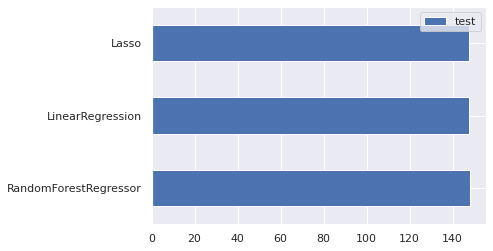

In [92]:
def ploting_mse():
  return mae.sort_values(by="test", ascending=False).plot(kind="barh"), plt.savefig("mse.jpg")

ploting_mse();

Fitur scaling

In [28]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

y_train = y_train.to_numpy().reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(y_train)
y_train = scaler.transform(y_train)

Ubah fitur testing kedalam numerik

In [29]:
X_test = X_test.squeeze().map(datetime.datetime.toordinal).to_numpy().reshape(-1,1)
X_test

array([[734442],
       [735446],
       [734563],
       ...,
       [734685],
       [728811],
       [731916]])

Buat model linear regression

In [30]:
model = LinearRegression()
model.fit(X_train, y_train)

scaler = MinMaxScaler()
scaler.fit(X_test_pred)
X_test_pred = scaler.transform(X_test_pred)

y_pred = model.predict(X_test_pred).flatten()*1e6
y_pred = y_pred.round(1)

Buat fungsi prediksi dengan input manual

In [31]:
def manual_input(dukun):
  # test = pd.DataFrame(dukun)
  test = pd.Series(dukun, dtype="datetime64[ns]").map(datetime.datetime.toordinal).to_numpy().reshape(-1,1)
  a = test - X_test.min() / X_test.max() - X_test.min()
  y_pred = model.predict(a)*1e2
  return y_pred.round(1)

# manual_input(X_test[:15])
manual_input(["2020-12-01"])

array([[462273.1]])

Tampilkan hasil aktual dan hasil prediksi dalam dataframe

In [32]:
hasil = pd.DataFrame({
    "y_test":y_test[:15],
    "y_pred":y_pred[:15]
})
hasil

,y_test,y_pred
10140,357548.0,353820.2
7465,270521.0,407522.2
808,348611.0,360292.3
7666,233449.0,244704.6
2624,325025.0,376659.6
6448,224800.0,222025.7
5434,95030.0,41236.1
4604,132325.0,160086.5
13302,70612.0,112803.1
6708,126776.0,155219.1


Tampilkan garis prediksi

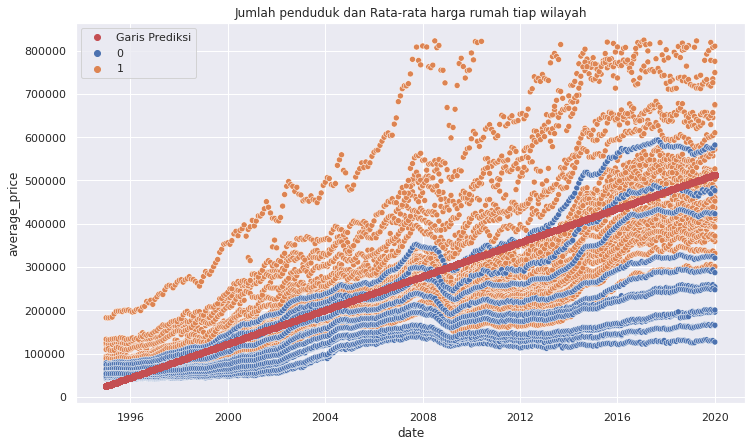

In [33]:
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(x="date", y="average_price", hue="borough_flag", data=data)
plt.plot(X_plot_pred, y_pred, "ro", markersize=6, label="Garis Prediksi")
plt.title("Jumlah penduduk dan Rata-rata harga rumah tiap wilayah")
plt.legend()
plt.savefig("scatter_pred.jpg")
plt.show()

## Menggunakan Deeplearning

Buat objek earlystopping

In [84]:
es = EarlyStopping(monitor="loss", mode="min", verbose=1, patience=20)

Buat sebuah arsitektur neural network

In [85]:
model = Sequential([
    layers.Dense(16, activation="relu", input_shape=(1,)),
    layers.Dropout(0.1),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="linear")
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss="mse"              
)

history = model.fit(X_train, y_train, callbacks=[es], epochs=1000)

Epoch 1/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0302
Epoch 2/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0197
Epoch 3/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0195
Epoch 4/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 5/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 6/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0192
Epoch 7/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.0192
Epoch 8/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 9/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0192
Epoch 10/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0191
Epoch 11/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0192
Epoch 12/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0192
E

Ploting hasil training neural network

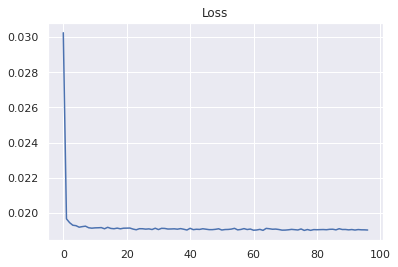

In [86]:
def ploting(a):
  plt.plot(a)
  plt.title("Loss")
  plt.savefig("loss.jpg")
  plt.show()

ploting(history.history["loss"])

Buat input prediksi dengan input manual

In [88]:
def masukan_manual(dukun):
  # Input manual
  test = pd.Series(dukun, dtype="datetime64[ns]").map(datetime.datetime.toordinal).to_numpy().reshape(-1,1)
  a = test - X_test.min() / X_test.max() - X_test.min()
  y_pred = model.predict(a)*1e2
  return np.abs(y_pred.round(1))

masukan_manual(["2020-12-01"])

array([[379494.9]], dtype=float32)

Buat objek prediksi, kemudian tampilkan dalam bentuk dataframe antara hasil aktual dan prediksi

In [89]:
y_pred_deep = model.predict(X_test_pred).flatten()*1e6
y_pred_deep = np.round(y_pred_deep)


banding = pd.DataFrame({
    "y_test":y_test[:10],
    "y_pred":y_pred_deep[:10]
})
banding

,y_test,y_pred
10140,357548.0,337066.0
7465,270521.0,386119.0
808,348611.0,342977.0
7666,233449.0,237244.0
2624,325025.0,357928.0
6448,224800.0,215053.0
5434,95030.0,43842.0
4604,132325.0,154446.0
13302,70612.0,108179.0
6708,126776.0,149683.0


Tampilkan garis prediksi

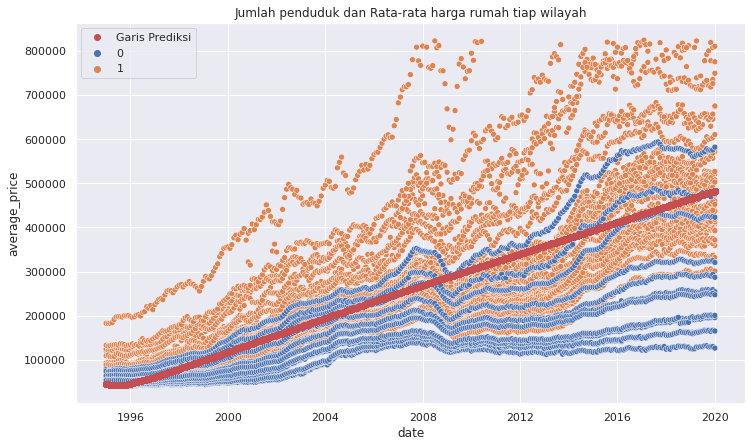

In [90]:
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(x="date", y="average_price", hue="borough_flag", data=data)
plt.plot(X_plot_pred, y_pred_deep, "ro", markersize=6, label="Garis Prediksi")
plt.title("Jumlah penduduk dan Rata-rata harga rumah tiap wilayah")
plt.legend()
plt.savefig("scatter_pred_2.jpg") 
plt.show()

Bandingkan hasil prediksi

In [91]:
pd.DataFrame({
    "y_aktual":y_test[:20],
    "y_pred":y_pred[:20],
    "y_pred_deep":y_pred_deep[:20]
})

,y_aktual,y_pred,y_pred_deep
10140,357548.0,353820.2,337066.0
7465,270521.0,407522.2,386119.0
808,348611.0,360292.3,342977.0
7666,233449.0,244704.6,237244.0
2624,325025.0,376659.6,357928.0
6448,224800.0,222025.7,215053.0
5434,95030.0,41236.1,43842.0
4604,132325.0,160086.5,154446.0
13302,70612.0,112803.1,108179.0
6708,126776.0,155219.1,149683.0
